# River Non River image classification using Logistic Regression


---



In [0]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
from numpy.linalg import inv
import random
import os
import cv2

In [0]:
riverPoint = 50
nonRiverPoint = 100
channel = 4 #features 
imageDim = 512
dataset_path = 'images/'
riverPointFile = 'RiverPoints.txt'
nonRiverPointFile = 'NonRiverPoints.txt'
lam = 190
alpha = .001
iters = 2100


### 4 Band Images are marged in a single image

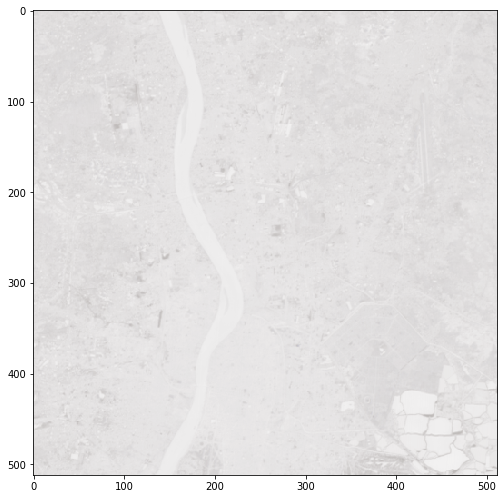

In [560]:
dataset_dir  = os.listdir(dataset_path)
imageArray = np.ndarray(shape=(imageDim,imageDim,channel), dtype=np.integer)

for i in range(channel):
    img = imread(dataset_path + str(i+1)+'.gif')
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)[:,:,:1].reshape((img.shape[0], img.shape[1]))
    imageArray [:,:,i] = np.array(img[:,:,0])
plt.subplot(1,1,1)
plt.imshow(imageArray)
plt.subplots_adjust(right=1.2, top=2.5)
plt.show()




### 50 river x,y location taken from RiverPoints.txt file and 100 non river x,y location taken from NonRiverPoint.txt file 


In [0]:
x_r=[]
y_r=[]
x_nr=[]
y_nr=[]

with open(riverPointFile,'r') as fp:
    point = fp.readline()
    while point:
        point = point.split()
        point = [int(val) for val in point]
        x_r.append(point[0])
        y_r.append(point[1])
        point = fp.readline()
with open(nonRiverPointFile,'r') as fp:
    point = fp.readline()
    while point:
        point = point.split()
        point = [int(val) for val in point]
        x_nr.append(point[0])
        y_nr.append(point[1])
        point = fp.readline()



### Organised and mean normalized training data 



```
 X = (50 river pixel value + 100 non river pixel value)
 Y = 150 binary class array (1 : river , 0 : non river) 
```



In [0]:
Y=np.ndarray(shape=(riverPoint+nonRiverPoint,1), dtype=np.integer)

R=np.ndarray(shape=(riverPoint,channel))
one = np.ones((1,channel))
for i in range(riverPoint):
  R[i] =  imageArray[x_r[i],y_r[i],:]
  Y[i] = 1  #river class

NR=np.ndarray(shape=(nonRiverPoint,channel),dtype=np.integer)

for i in range(nonRiverPoint):
  NR[i] =  imageArray[x_nr[i],y_nr[i],:]
  Y[i+riverPoint] = 0 #non river class

train = np.concatenate((R,NR),axis=0)


mean=np.mean(train,axis=0)
std =np.std(train,axis=0)

train=np.subtract(train,mean)
train=np.divide(train,std)

ones = np.ones((riverPoint+nonRiverPoint,1))
train=np.concatenate((ones,train),axis=1)

YY = Y
ym = np.mean(Y)
Y= (Y-ym)/np.std(Y)                   


### Functions
Cost Function
# ![Cost ](https://miro.medium.com/max/2836/1*_52kKSp8zWgVTNtnE2eYrg.png)

Sigmoid Function
![alt text](https://miro.medium.com/max/1046/1*l59BUnPwWHMf1H-GNxgZHQ.png)

In [0]:
def computeCost(X,Y,theta, lam):
    h = sigmoid(X@theta.T)
    lam_matrix = lam * np.ones(theta.shape)
    lam_matrix[0][0] = 0
    cost = -1 * np.sum(( np.multiply(Y,np.log(h)) + np.multiply((1 - Y),np.log(1-h))),axis= 0 )

    return cost / len(X) + np.sum(np.power( (lam_matrix),2))/ (2* len(X))

def sigmoid(thetax):
  return (1 / (1 + np.exp(-1 * thetax)))

###Gradient Descent

![alt text](https://miro.medium.com/max/2866/1*Ecea3jVIRxK4Mkrh_Nie4w.jpeg)

In [0]:
def gradientDescent(X,y,theta,iters,alpha):
  costs = []
  for i in range(iters):   
    gx = sigmoid(X@theta.T)
    
    theta = theta - (alpha / len(X )) * (np.subtract(gx, y).T@X)
    costs.append( computeCost(X, y, theta, 0))
  return theta, costs

with regularization


![alt text](http://pingax.com/wp-content/uploads/2014/05/regularized-gradient.png)

In [0]:
def gradientDescentWithReg(X,y,theta1,iters,alpha, lam):
    costs = []
    lam_matrix = lam * np.ones(theta1.shape)
    lam_matrix[0][0] = 0
    
    for i in range(iters):

        h = X@theta1.T 
        gx = sigmoid(h)
        theta1 = theta1*(1- alpha*lam_matrix / len(X)) - (alpha / len(X)) * ((gx - y).T@X)
        costs.append(computeCost(X, y, theta1, lam))
        
    return theta1 , costs 

###Computation

In [0]:
theta = np.zeros([1,channel+1])  
thetaL = np.zeros([1,channel+1])
theta, costs = gradientDescent(train,Y,theta,iters,alpha)
thetaL, costsR = gradientDescentWithReg(train,Y,thetaL,iters,alpha,lam)

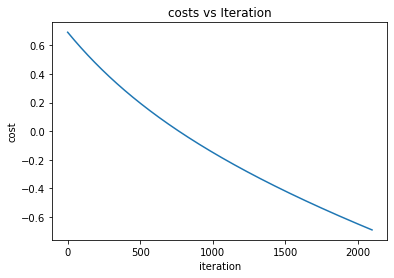

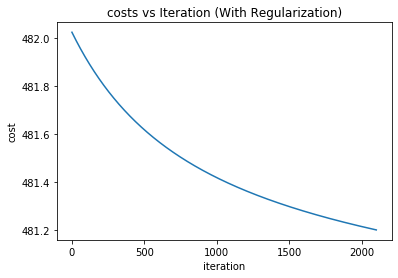

In [567]:
plt.plot(range(iters),costs) 
plt.xlabel('iteration') 
plt.ylabel('cost') 
plt.title('costs vs Iteration') 
plt.show()

plt.plot(range(iters),costsR) 
plt.xlabel('iteration') 
plt.ylabel('cost') 
plt.title('costs vs Iteration (With Regularization)') 
plt.show()

### Prediction & calculate accuracy on test data

In [0]:
out_image=np.ndarray(shape=(imageDim, imageDim), dtype = np.integer)
out_imageReg=np.ndarray(shape=(imageDim, imageDim), dtype = np.integer)
 
regError = 0
for i in range(imageDim):
  for j in range(imageDim):
    pix = np.concatenate(([1],np.divide(np.subtract(imageArray[i,j,:],mean),std)),axis = 0)
    predictedPix = sigmoid(pix@theta.T)
    predictedPixReg = sigmoid(pix@thetaL.T)
    
    if predictedPix >0.5:
      predictedPix = 255 #white river
    else:
      predictedPix = 0 #black
    
    if predictedPixReg >0.5:
      predictedPixReg = 255 #white river
    else:
      predictedPixReg = 0 # black
    out_image[i,j] = predictedPix
    out_imageReg[i,j] = predictedPixReg
    

In [569]:
sample_out_img = imread('ErrorFree.jpeg')
count = 0
countR = 0
for i in range(512):
    for j in range(512):
        if sample_out_img[i,j]==out_image[i,j]:
            count = count+1
        if sample_out_img[i,j]==out_imageReg[i,j]:
            countR = countR+1   
print('Accuracy without Regularization',count*100/(imageDim*imageDim),'%')
print('Accuracy with Regularization',countR*100/(imageDim*imageDim),'%')

Accuracy without Regularization 94.43244934082031 %
Accuracy with Regularization 96.62818908691406 %


### Results 


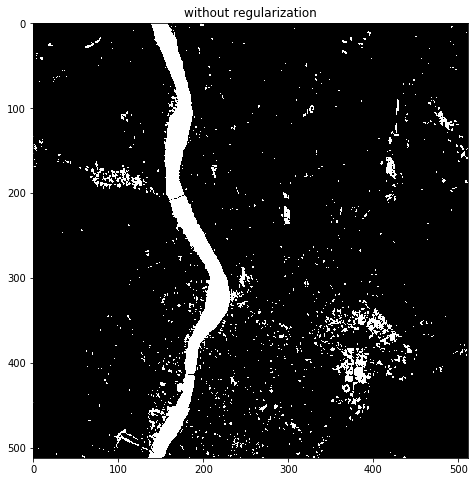

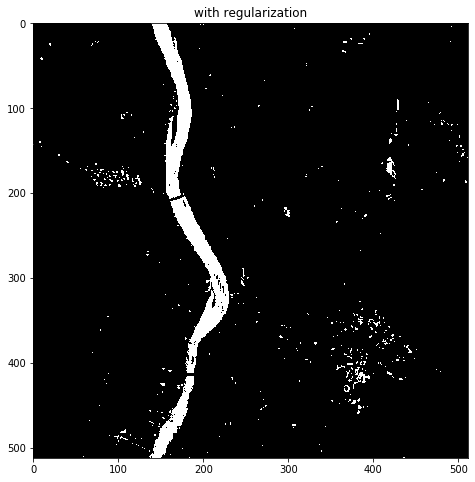

In [570]:
plt.figure(figsize=(8,8))
plt.title("without regularization")
plt.imshow(out_image, cmap = 'gray')
plt.figure(figsize=(8,8))
plt.title("with regularization")
plt.imshow(out_imageReg, cmap = 'gray')